In [ ]:
#Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
import timeit

In [ ]:
#Data

#BT Thermal
#filepath1 = '/content/drive/MyDrive/Colab Notebooks/Data/Train_BT_Heat_Rate.csv'
#filepath2 = '/content/drive/MyDrive/Colab Notebooks/Data/Test_BT_Heat_Rate.csv'

#GF Immersion
#filepath1 = '/content/drive/MyDrive/Colab Notebooks/Data/Train_Geroge_Fox_Immersion_Heat(KWh)_Rate.csv'
#filepath2 = '/content/drive/MyDrive/Colab Notebooks/Data/Test_George_Fox_Immersion_Heat(KWh)_Rate.csv'

# Temperature
#filepath1 = '/content/drive/MyDrive/Colab Notebooks/Data/Train_George_Fox_temp(DegC).csv'
#filepath2 = '/content/drive/MyDrive/Colab Notebooks/Data/Test_George_Fox_temp(DegC).csv'

#GF B27 Thermal
#filepath1 = '/content/drive/MyDrive/Colab Notebooks/Data/Train_George_Fox_Thermal(KWh)_Rate.csv'
#filepath2 = '/content/drive/MyDrive/Colab Notebooks/Data/Test_George_Fox_Thermal(KWh)_Rate.csv'

# BT Oc
#filepath1 = '/content/drive/MyDrive/Colab Notebooks/Data/BT_Oc_Train.csv'
#filepath2 = '/content/drive/MyDrive/Colab Notebooks/Data/BT_Oc_Test.csv'

# Library Oc
#filepath1 = '/content/drive/MyDrive/Colab Notebooks/Data/Library_Train.csv'
#filepath2 = '/content/drive/MyDrive/Colab Notebooks/Data/Library_Test.csv'

train = pd.read_csv(filepath1)
test = pd.read_csv(filepath2)
train.head()

,time,Associated Client Count
0,2018-08-20 00:00:00,33
1,2018-08-20 01:00:00,37
2,2018-08-20 02:00:00,38
3,2018-08-20 03:00:00,33
4,2018-08-20 04:00:00,36


In [ ]:
#Data Manipulation
train.columns = ['timestamp','reading']
test.columns = ['timestamp','reading']
train.timestamp = pd.to_datetime(train.timestamp)
test.timestamp = pd.to_datetime(test.timestamp)
train.set_index('timestamp', inplace=True)
test.set_index('timestamp', inplace=True)
#train = train.resample('1H').asfreq()
#test = test.resample('1H').asfreq()
#train = train.resample('1H').sum()
#test = test.resample('1H').sum()
test.dropna(inplace=True)
train.dropna(inplace=True)
train.tail()

,reading
timestamp,
2019-12-09 19:00:00,26992
2019-12-09 20:00:00,25062
2019-12-09 21:00:00,21944
2019-12-09 22:00:00,15728
2019-12-09 23:00:00,13128


In [ ]:
#Preprocessing functions for XGBoost
def shift(data, shift):
    for x in range(shift):
      if x == 0:
        pass
      else:
        data['step-' + str(x)] = data.reading.shift(periods=x)
    return data

def add_time_data(inp_dat):
    dat = inp_dat.copy()
    dat['hour'] = dat.index.hour
    dat['day'] = dat.index.dayofweek
    return dat

def XandY(inp_data, y_col):
    X = inp_data.drop(y_col, axis=1)
    y = inp_data[y_col]
    y = pd.DataFrame(y)
    return X, y


#Variables
n_in = 336 #Length of window (Input Sequece)
pred_hor = 48

#Implementation
train = shift(train, n_in)
test = shift(test, n_in)
train = train.dropna()
test = test.dropna()
train = add_time_data(train)
test = add_time_data(test)

train_X, train_y = XandY(train, reading)
test_X, test_y = XandY(test, reading)

val_X = train_X[-pred_hor:]
val_y = train_y[-pred_hor:]
train_X = train_X[:-pred_hor]
train_y = train_y[:-pred_hor]

In [ ]:
#Optimising
#Hyperparameters
parameter_grid = {'max_depth':[2, 4, 6, 8, 12], 'learning_rate':[0.01, 0.1, 0.2, 0.3]}

#Defining Model and GridSearch
model = XGBRegressor(n_estimators=800)
Optimiser = GridSearchCV(estimator=model, param_grid=parameter_grid, n_jobs=-1, cv=TimeSeriesSplit(n_splits=2).get_n_splits([train_X, train_y]), verbose=4)

#Fitting Model
Optimiser.fit(train_X, train_y, early_stopping_rounds=5, eval_set=[(val_X, val_y)], eval_metric='mae')
outputinfo = pd.DataFrame(Optimiser.cv_results_)

Fitting 2 folds for each of 20 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


KeyboardInterrupt: ignored

In [ ]:
#Saving Gridsearch
outputinfo.to_csv('/content/drive/MyDrive/Colab Notebooks/GridSearch Results Thermal/XGBoost_BTThermal_hour_GridSearch_Results.csv')

In [ ]:
#Locating best hyperparameters
best = outputinfo.loc[outputinfo['rank_test_score'] == 1]
best

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
11,0.94549,0.156738,0.030244,0.000652,0.2,4,"{'learning_rate': 0.2, 'max_depth': 4}",0.624502,0.703807,0.664155,0.039652,1


In [ ]:
#Training
start = timeit.default_timer()

XGBoostModel = XGBRegressor(max_depth=4, learning_rate=0.1, n_estimators=800)
XGBoostModel.fit(train_X, train_y, early_stopping_rounds=5, eval_set=[(val_X, val_y)], eval_metric='mae')

stop = timeit.default_timer()
print('Time: ', stop - start)  

[10:57:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:17909.4
Will train until validation_0-mae hasn't improved in 5 rounds.
[1]	validation_0-mae:16206
[2]	validation_0-mae:14689.7
[3]	validation_0-mae:13291.6
[4]	validation_0-mae:12053.1
[5]	validation_0-mae:10949
[6]	validation_0-mae:9965.51
[7]	validation_0-mae:9073.97
[8]	validation_0-mae:8296.33
[9]	validation_0-mae:7580.55
[10]	validation_0-mae:6941.46
[11]	validation_0-mae:6349.77
[12]	validation_0-mae:5803.79
[13]	validation_0-mae:5340.61
[14]	validation_0-mae:4918
[15]	validation_0-mae:4560.41
[16]	validation_0-mae:4214.47
[17]	validation_0-mae:3915.11
[18]	validation_0-mae:3621.88
[19]	validation_0-mae:3382.73
[20]	validation_0-mae:3165.74
[21]	validation_0-mae:2990.7
[22]	validation_0-mae:2831.81
[23]	validation_0-mae:2706.08
[24]	validation_0-mae:2595.14
[25]	validation_0-mae:2477.52
[26]	validation_0-mae:2391.12
[27]	validation_0-

In [ ]:
#Saving the XGBoost Model
#XGBoostModel.save_model('/content/drive/MyDrive/Colab Notebooks/Saved Temperature Models/XGBoost_Temp_Model.txt')

#Loading an XGBoost Model
XGBoostModel = XGBRegressor()
XGBoostModel.load_model('/content/drive/MyDrive/Colab Notebooks/Saved Temperature Models/XGBoost_Temp_Model.txt')

[13:31:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
#Testing
def predict(input, pred_hor):
    output = []
    #input = pd.DataFrame(input)
    for x in range(pred_hor):
      pred = XGBoostModel.predict(input)
      output.append(pred)
      h = int(input.hour)
      d = int(input.day)
      input = input.shift(axis=1)
      input['step-1'] = pred
      if h == 23:
        input['hour'] = 0
      else:
        input['hour'] = h+1
      if d == 6:
        input['day'] = 0
      else:
        input['day'] = d+1
    return output

def averageMAE(true, preds):
    ae = [0]*len(preds)
    for x in range(len(preds)):
      ae[x] = mean_absolute_error(true.iloc[x], preds[x])
    return (sum(ae))/len(preds)

def testing(model, test_X, test_y):
  testgrid = test_X.iloc[0::pred_hor]
  err = []
  for x in range((testgrid.shape[0])-1):
    p = predict(testgrid.iloc[x:(x+1)], pred_hor)
    truth = test_y.iloc[x*pred_hor:((x*pred_hor)+pred_hor)]
    MAE = averageMAE(truth, p)
    err.append(MAE)
  errDF = pd.DataFrame(err)
  return errDF

#Implementation
output = testing(XGBoostModel, test_X, test_y)
output.describe()

,0
count,2.000000
mean,2698.665085
std,1656.637003
min,1527.245826
25%,2112.955455
50%,2698.665085
75%,3284.374714
max,3870.084343


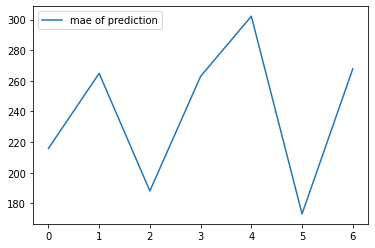

In [ ]:
#Visualisations of MAE for each test set
plt.plot(output, label='mae of prediction')
plt.legend()

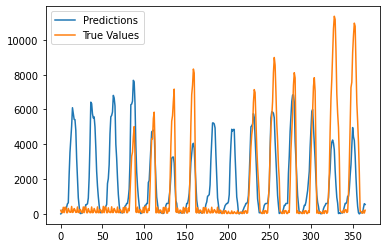

In [ ]:
y = np.array(test_y.iloc[0:pred_hor])
p = predict(test_X.iloc[0:1], pred_hor)
plt.plot(p, label='Predictions')
plt.plot(y, label='True Values')
plt.legend() 